In [14]:
import numpy as np
import pandas as pd 
import pickle
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import model as mu
import nn_utils as nu
import data_utils as du
import data_augment as da

In [15]:
data_path = 'data/udacity/'
df_drive = pd.read_csv(data_path + 'driving_log.csv')
df_drive.loc[:,'center'] = df_drive['center'].apply(lambda x: x.strip())
df_drive.loc[:,'left']   = df_drive['left'].apply(lambda x: x.strip())
df_drive.loc[:,'right']  = df_drive['right'].apply(lambda x: x.strip())
print("Number Obs: {}, Number Features: {}".format(*df_drive.shape))
df_drive.head()

Number Obs: 8036, Number Features: 7


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


Image Dimensions: (160, 320, 3)


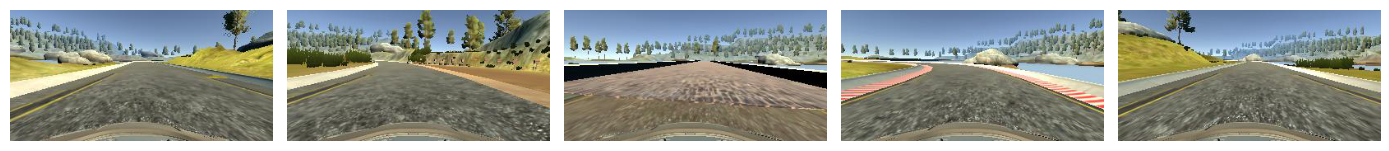

In [16]:
def set_axi_opts(axi, **kwargs):
    axi.grid(False)
    axi.get_yaxis().set_visible(False)
    axi.get_xaxis().set_ticks([])
    if 'title'  in kwargs: axi.set_title(kwargs['title'])
    if 'xlabel' in kwargs: axi.set_xlabel(kwargs['xlabel'])

def get_image(sample_idx, col='center'):
    ds_sample  = df_drive.ix[sample_idx]
    img_sample = data_path + ds_sample[col].strip()
    img_data = mpimg.imread(img_sample)
    return img_data
  
# sample of center images 
fig, ax = plt.subplots(1, 5, figsize=(14,16))
axes = ax.flatten()
rand_idxs = np.random.randint(0, len(df_drive),len(axes))
image_dim = get_image(rand_idxs[0]).shape
print("Image Dimensions: {}".format(image_dim))
for axi, sample_idx in zip(axes, rand_idxs):
    axi.imshow(get_image(sample_idx))
    set_axi_opts(axi)
plt.tight_layout()

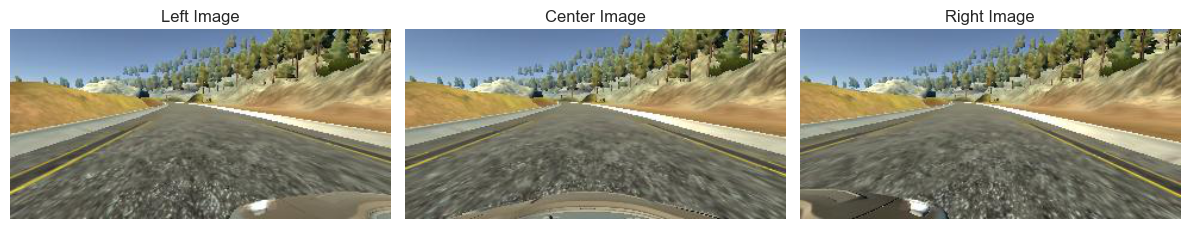

In [17]:
# sample snapshot of left, center, right instance
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,6))
sample_idx = np.random.randint(0, len(df_drive), 1)[0]
titles = ['Left Image', 'Center Image', 'Right Image']
ax1.imshow(get_image(sample_idx, col='left'))
ax2.imshow(get_image(sample_idx, col='center'))
ax3.imshow(get_image(sample_idx, col='right'))
_ = [set_axi_opts(axi, **{'title': title}) for axi,title in zip([ax1,ax2,ax3], titles)]
plt.tight_layout()

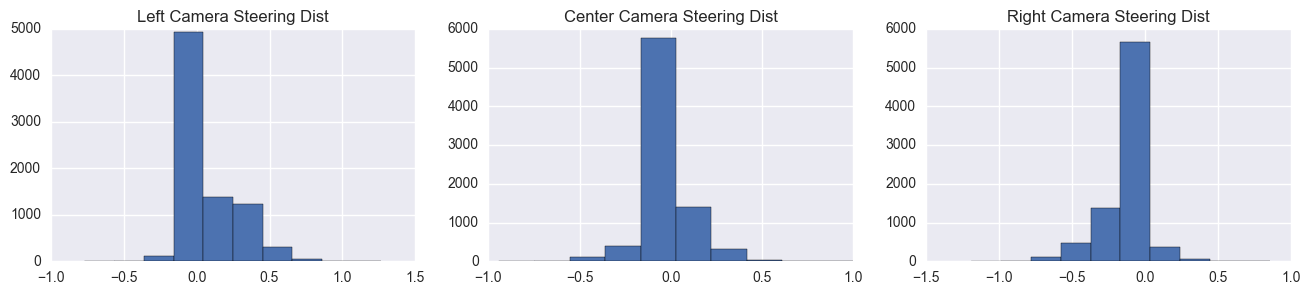

In [22]:
# plot distribution of steering angles w/small lateral shifts
def plot_steering_dist(df_dist):
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16,3))
    df_dist['left_steering'].hist(ax=ax1)
    df_dist['steering'].hist(ax=ax2)
    df_dist['right_steering'].hist(ax=ax3)
    titles = ['Left Camera Steering Dist', 'Center Camera Steering Dist', 'Right Camera Steering Dist']
    [axi.set_title(title) for axi, title in zip((ax1,ax2,ax3),titles)]
    
df_drive_shift = du.lateral_shift(df_drive)
_ = plot_steering_dist(df_drive_shift)

In [25]:
# partition into train/test split
df_drive_samples = du.combine_dataset(df_drive_shift)
print("New Dimensions: {}".format(df_drive_samples.shape))
nu.partition_samples(df_drive_samples)
X_train, y_train, X_val, y_val = nu.load_partitions()
train, validation = ((X_train, y_train), (X_val, y_val))
# Define Model
params={'dropout_proba': 0.25}
model = mu.create_model(learning_rate=1e-4, loss_metric='mse', **params)
mu.save_architecture(model)
#model.summary()

New Dimensions: (11711, 2)
Number Train Obs: 9368, Validation Obs: 2343


In [37]:
# Train the model w/generators
params = {'num_epochs': 2, 'batch_size': 64}
mu.train(train, validation, model, **params)

Epoch 1/2
9368/9368 [==============================] - 149s - loss: 1.4721 - acc: 0.1206 - val_loss: 0.1396 - val_acc: 0.3781
Epoch 2/2
9368/9368 [==============================] - 236s - loss: 1.4793 - acc: 0.1249 - val_loss: 0.1379 - val_acc: 0.3781
Training time: 3.9e+02 sec 6.4 min
Model Saved: ./ckpts/model.h5, ./ckpts/model.json
